In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

import astropy.units as u

In [135]:
# Find core radius from mass
def degenerate_core_radius(M_o):
    """Find radius of core from its mass assuming it's composed of degenerate matter.

    Parameters
    ----------
    M_o : float
        Mass of stellar core.

    Returns
    -------
    float
        Radius of stellar core
    """
    M_wd = (1898.13 * 1e24 * u.kg).to(u.solMass)
    R_wd = (71492 * u.km).to(u.astronomical_unit)
    eta = R_wd*((M_wd)**(1/3))
    return eta*M_o**(-1/3)

# Load interpolators and data

In [11]:
mass_loss = np.load("interpolator_mass_loss.npy", allow_pickle=True).item()
interp_radius = np.load("interpolator_radius.npy", allow_pickle=True).item()

In [12]:
M_o_range = np.loadtxt("data/M_o_range1.txt") * u.solMass
M_s_range = np.loadtxt("data/M_s_range1.txt") * u.solMass
print(M_s_range.shape, M_o_range.shape)

(15,) (15, 16)


In [13]:
def repack(M_s, R_s):
    points = []
    for i in range(len(M_s_range)):
        for j in range(len(R_s[i])):
            points.append([M_s[i, j], R_s[i, j]])
    return np.array(points, dtype=object)

In [14]:
M_s_range_2 = np.tensordot(M_s_range.value, np.ones(len(M_o_range[0])), axes = 0)
R_s_range = interp_radius(M_s_range_2, M_o_range)

points = repack(M_s_range_2, R_s_range)
result = M_o_range.value.reshape(np.shape(M_o_range)[0]*np.shape(M_o_range)[1])

core_mass = LinearNDInterpolator(points, result)

print(core_mass(M_s_range_2, R_s_range).shape)

(15, 16)


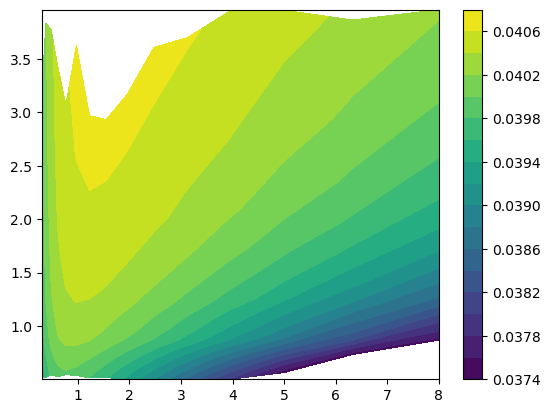

In [139]:
plt.contourf(M_s_range_2, R_s_range, M_o_range, levels=20)
plt.colorbar()

In [72]:
print(M_s_range_2[3, 0], R_s_range[3, 0])
print(core_mass(0.5, 0.518))

0.6062977870140857 0.5268725502446534
0.03953265676366526


# Solve evolution equation

In [84]:
def star_evo(M_s, M_o, m_dot, time=3e6):
    """Run evolution differential equation over a time span of 3 million years.

    Parameters
    ----------
    M_s : float
        Mass of star in solar masses.
    M_o : _type_
        Core mass in solar masses.
    m_dot : _type_
        Fraction of Eddington accretion rate of black hole.

    Returns
    -------
    tuple(float, float, float)
        Evaluation timesteps, star mass and star radius
    """
    R_s = (interp_radius(M_s, M_o) * u.astronomical_unit)

    # initialise arrays
    N = int(1e4) # integration steps 
    mass_t = np.zeros(N + 1) * u.solMass
    r_t = np.zeros(N + 1) * u.astronomical_unit

    mass_loss_0 = 10**(mass_loss(M_s.value, R_s.value, m_dot)) * u.solMass / u.a
    t_lose = M_s/mass_loss_0
    t_max = np.rint(np.nanmin([t_lose.value, time])).astype(int)
    #print("loss: ", M_s, R_s, mass_loss_0, t_max)

    t_eval = np.linspace(0, t_max, N + 1)
    dt = (t_eval[1] - t_eval[0]) * u.a

    for i, t in enumerate(t_eval):
        mass_t[i] = M_s
        r_t[i] = R_s
        M_dot = 10**(mass_loss(M_s.value, R_s.value, m_dot)) * u.solMass / u.a
        #print(i, M_s, R_s, M_dot)
        M_s -= M_dot*dt
        R_s = (interp_radius(M_s, M_o) * u.astronomical_unit)
    
    return t_eval, mass_t, r_t

In [85]:
def plot_evo_range(M_s_range, M_o_range, m_dot = 0.5, shape = (10, 3)):
    # Plot paramter space:
    x = np.linspace(0.5, 8, 100)
    y = np.linspace(0.5, 4, 100)
    X, Y = np.meshgrid(x, y)

    plt.contourf(X, Y, mass_loss(X, Y, m_dot), 20)
    plt.colorbar()

    # calculate evolutions for M values of M_o over N values of M_s
    N, M = shape
    ms_r = np.linspace(M_s_range[1], M_s_range[-2], N)

    for i, M_s in enumerate(ms_r):
        #print(i)
        mo_r = np.linspace(M_o_range[i, 1], M_o_range[i, -2], M)
        for j, M_o in enumerate(mo_r):
            t, m, r = star_evo(ms_r[i], mo_r[j], m_dot)
            plt.plot(m.value, r.value, label = str(i) +", " + str(j))

    plt.xlabel(r"Mass $(M_{\odot}$)")
    plt.ylabel("Radius (AU)")
    #plt.legend()

    plt.show()

loss:  0.37929416720912945 solMass 0.5188446292568641 AU nan solMass / a 3000000
loss:  0.37929416720912945 solMass 0.588310016070821 AU nan solMass / a 3000000
loss:  0.37929416720912945 solMass 0.9907274454010342 AU nan solMass / a 3000000
loss:  3.353418382355811 solMass 1.0603986721200582 AU 8.667067783189573e-11 solMass / a 3000000
loss:  3.353418382355811 solMass 1.2864703285121035 AU 1.1870847260213336e-09 solMass / a 3000000
loss:  3.353418382355811 solMass 1.6589370917107091 AU 1.6822296553742017e-08 solMass / a 3000000
loss:  6.327542597502492 solMass 2.1824094462389825 AU 7.429189003805629e-10 solMass / a 3000000
loss:  6.327542597502492 solMass 2.769192491121425 AU 1.2304720094937345e-08 solMass / a 3000000
loss:  6.327542597502492 solMass 3.7038596010116405 AU 1.5093781272875984e-07 solMass / a 3000000


KeyboardInterrupt: 

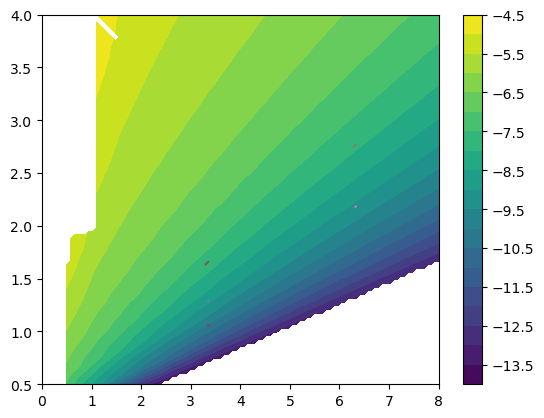

In [17]:
plot_evo_range(M_s_range, M_o_range,  m_dot = 0.3, shape = (3, 3))

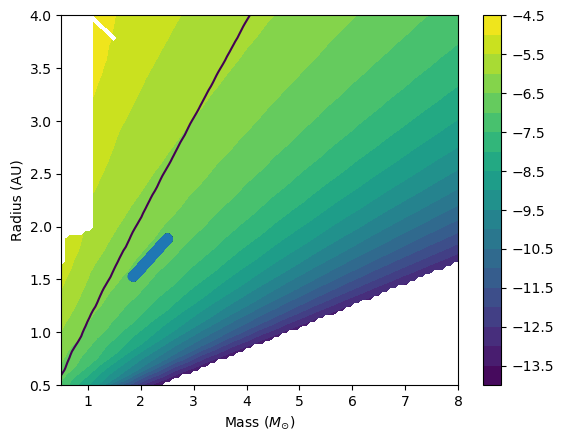

In [86]:
m_dot = 0.3
# Plot paramter space:
x = np.linspace(0.5, 8, 100)
y = np.linspace(0.5, 4, 100)
X, Y = np.meshgrid(x, y)

M_s = 2.5 * u.solMass
M_o = 0.0404 * u.solMass

evaporation_time = X/10**mass_loss(X, Y, m_dot)

plt.contour(X, Y, evaporation_time, levels = [3e6])
plt.contourf(X, Y, mass_loss(X, Y, m_dot), 20)

plt.colorbar()

t, m, r = star_evo(M_s, M_o, m_dot)

plt.scatter(m.value, r.value)

plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")

#plt.xlim(np.nanmin(0.9*m.value), np.nanmax(1.1*m.value))
#plt.ylim(np.nanmin(0.9*r.value), np.nanmax(1.1*r.value))

plt.show()

In [178]:
def last_nan(my_list):
    """
    Returns the index of the last value in the list that is neither nan nor none.
    """
    for i in range(len(my_list)-1, -1, -1):
        if my_list[i] is not None and not np.isnan(my_list[i]):
            return i
    return 0

def end_result(M_s, M_o, m_dot, time=3e6):
    _, m, r = star_evo(M_s, M_o, m_dot)
    a, b = last_nan(m), last_nan(r)
    index = min(a, b)
    return m[index], r[index]

def find_remaining_mass(mass_array, radius_array, m_dot, time=3e6):
    final_mass = np.zeros(mass_array.shape) * u.solMass
    final_radius = np.zeros(radius_array.shape) * u.astronomical_unit

    for i, m in enumerate(mass_array):
        print(i)
        for j, r in enumerate(radius_array[i]):
            m_c = core_mass(m[j], r)
            result_mass, _ = end_result(m[j] * u.solMass, m_c * u.solMass, m_dot, time)
            final_mass[i, j] = result_mass

    return final_mass

def color_parameter_space(mass_array, radius_array, m_dot, time=3e6):
    final_mass = find_remaining_mass(mass_array, radius_array, m_dot, time)
    return np.log10(final_mass.value/mass_array)

0
1
2
3
4
5
6
7
8
9


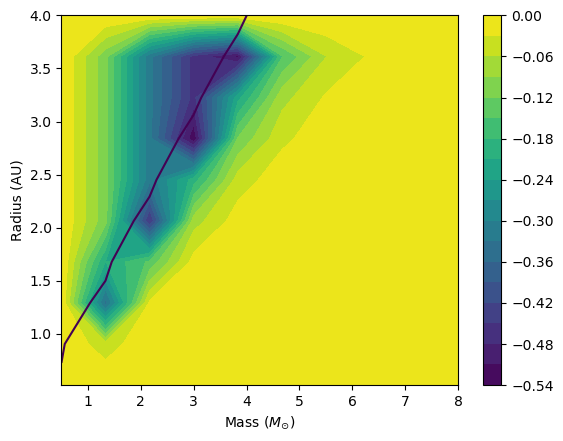

In [179]:
m_dot = 0.3
x = np.linspace(0.5, 8, 10)
y = np.linspace(0.518, 4, 10)
mass, radius = np.meshgrid(x, y)

color = color_parameter_space(mass, radius, m_dot, time = 1e6) #log of the final mass

evaporation_time = mass/10**mass_loss(mass, radius, m_dot)

plt.contour(mass, radius, evaporation_time, levels = [3e6])
plt.contourf(mass, radius, color, 20)

plt.colorbar()

plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")

plt.show()


In [182]:
m_dot = 0.3
# Plot paramter space:
x = np.linspace(0.5, 8, 100)
y = np.linspace(0.5, 4, 100)
X, Y = np.meshgrid(x, y)

evaporation_time = X/10**mass_loss(X, Y, m_dot)

plt.contour(X, Y, evaporation_time, levels = [3e6])
plt.contourf(X, Y, mass_loss(X, Y, m_dot), 20)

cbar = plt.colorbar()
ticks = [-5, -6, -7, -8, -9, -10, -11, -12, -13, -14]
cbar.set_ticks(ticks)

m_o_list = np.array([0.0404, 0.0405, 0.0406]) * u.solMass 
m_s_list = 2.5*u.solMass * np.ones(m_o_list.shape)

for i in range(len(m_o_list)):
    start_m, start_r = m_s_list[i], interp_radius(m_s_list[i], m_o_list[i])
    plt.scatter(start_m, start_r)
    m, r = end_result(m_s_list[i], m_o_list[i], m_dot)
    plt.scatter(m*u.solMass, r*u.astronomical_unit)
    print(start_m.value, start_r)
    print(m.value, r.value)

    #plt.scatter(m.value, r.value, label = i, marker=".")

plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")

#plt.xlim(np.nanmin(0.9*m.value), np.nanmax(1.1*m.value))
#plt.ylim(np.nanmin(0.9*r.value), np.nanmax(1.1*r.value))

plt.show()